# Challenge

## Download and install Spark

In [1]:
!ls

sample_data


In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [817 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports In

## Setup environment

In [3]:
import os
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jre1.8.0_341"
os.environ["SPARK_HOME"] = "C:/app/spark-3.3.0-bin-hadoop3"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [4]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
!ls -l

--2022-07-25 12:58:14--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [ <=>                ]   1.67G   871KB/s    in 40m 53s 

2022-07-25 13:39:08 (713 KB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1791192066]

total 1969816
-rw-r--r--  1 root root 1791192066 Jul 25 10:46 'rows.csv?accessType=DOWNLOAD'
drwxr-xr-x  1 root root       4096 Jul 13 13:43  sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018  spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018  spark-2.3.1-bin-hadoop2.7.tgz


In [5]:
!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
!ls -l

total 1969816
-rw-r--r--  1 root root 1791192066 Jul 25 10:46 reported-crimes.csv
drwxr-xr-x  1 root root       4096 Jul 13 13:43 sample_data
drwxrwxr-x 13 1000 1000       4096 Jun  1  2018 spark-2.3.1-bin-hadoop2.7
-rw-r--r--  1 root root  225883783 Jun  1  2018 spark-2.3.1-bin-hadoop2.7.tgz


In [6]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Challenge questions

**What is the most frequently reported non-criminal activity?**

In [7]:
rc.cache()
rc.count()

6755465

In [9]:
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(35, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [10]:
nc = rc.filter((col('Primary Type')=='NON - CRIMINAL')|(col('Primary Type')=='NON-CRIMINAL')|(col('Primary Type')=='NON-CRIMINAL (SUBJECT SPECIFIED)'))

In [11]:
nc.groupBy(col('Description')).count().orderBy(col('count'),ascending=False).show(truncate=False)

+-----------+-----+
|Description|count|
+-----------+-----+
+-----------+-----+



**Using a bar chart, plot which day of the week has the most number of reported crime. 
**

In [12]:
from pyspark.sql.functions import dayofweek , date_format

In [13]:
rc.select(col('Date'),dayofweek(col('Date')), date_format(col('Date'),'E'))

DataFrame[Date: timestamp, dayofweek(Date): int, date_format(Date, E): string]

In [14]:
rc.groupBy(date_format(col('Date'),'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=912241),
 Row(date_format(Date, E)='Mon', count=953056),
 Row(date_format(Date, E)='Thu', count=964913),
 Row(date_format(Date, E)='Sat', count=965428),
 Row(date_format(Date, E)='Wed', count=974197),
 Row(date_format(Date, E)='Fri', count=1017293),
 Row(date_format(Date, E)='Tue', count=968337)]

In [15]:
dow = [x[0] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]

In [16]:
cnt  = [x[1] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
cp = pd.DataFrame({'Day_of_week' : dow , 'Count': cnt})

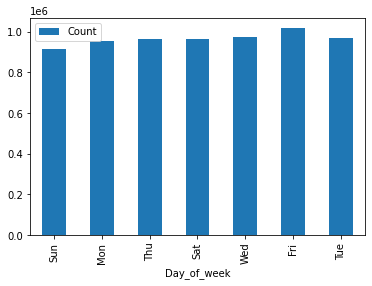

In [19]:
cp.plot(kind = 'bar', x='Day_of_week' , y='Count')